<a href="https://colab.research.google.com/github/GeronimoQB/CT_Algoritmos/blob/main/1_Algoritmos_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelos de regresión para estimar volumen forestal

**Curso–Taller:** Algoritmos de Inteligencia Artificial como Insumos Clave para la Silvicultura de Precisión  

Este cuaderno en Google Colab está organizado por **algoritmo** para que las y los participantes puedan:

- Cargar y explorar una base de datos forestal (por ejemplo, volumen por árbol o por parcela).  
- Preparar los datos (selección de variables, partición en entrenamiento / validación / prueba y estandarización).  
- Entrenar distintos modelos de **regresión supervisada** en Scikit‑Learn.  
- Evaluar cada algoritmo con métricas cuantitativas (RMSE, MAE, R²).  
- Comparar el desempeño de todos los modelos mediante tablas y gráficas.

> **Nota:** Ajusta los nombres de columnas (`feature_cols` y `target_col`) para que coincidan con tu archivo `volume.xlsx`.


## 1. Importación de librerías

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Opcional: mostrar tablas más anchas
pd.set_option('display.width', 1200)
pd.set_option('display.max_columns', None)

print("Librerías importadas correctamente.")

Librerías importadas correctamente.


## 2. Carga y exploración de datos

En esta sección se lee el archivo Excel con la información forestal (por ejemplo: diámetro normal, altura total, área basal, especie, volumen, etc.).  
Luego se muestran las primeras filas para revisar que los nombres de columnas y tipos de datos sean correctos.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Ruta del archivo de datos
# Asegúrate de que 'volume.xlsx' esté en el mismo directorio del cuaderno o en tu Google Drive.
file_path = '/content/drive/MyDrive/Curso-Taller_Algoritmos/data/volume.xlsx'  # <-- Puedes cambiar la ruta si es necesario

# Cargar datos en un DataFrame
df = pd.read_excel(file_path)

# Mostrar las primeras filas
df.head()

,plot,diameter,height,density,basal_area,volume,species
0,1,26.052632,9.771930,570,36.898791,234.746017,1
1,2,19.680851,9.425532,470,16.962244,119.527105,1
2,3,30.820513,12.743590,390,40.594089,271.784971,1
3,4,20.596491,9.280702,570,23.384445,144.925514,1
4,5,25.953488,10.953488,430,30.553559,248.498219,1


In [ ]:
# Información general de la tabla
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16251 entries, 0 to 16250
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   plot        16251 non-null  int64  
 1   diameter    16251 non-null  float64
 2   height      16251 non-null  float64
 3   density     16251 non-null  int64  
 4   basal_area  16251 non-null  float64
 5   volume      16251 non-null  float64
 6   species     16251 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 888.9 KB


## 3. Selección de variables y partición en conjuntos de entrenamiento, validación y prueba

1. Se seleccionan las columnas que se usarán como **variables explicativas** (`feature_cols`).  
2. Se define la columna objetivo (`target_col`), que en este caso representa el **volumen** a modelar.  
3. Se separan los datos en tres subconjuntos:
   - **Entrenamiento (Train)**: para ajustar los modelos.  
   - **Validación (Validation)**: para comparar modelos y afinar hiperparámetros.  
   - **Prueba (Test)**: para estimar el desempeño final.

> **Importante:** Modifica `feature_cols` y `target_col` para que coincidan con los nombres de tu base de datos.


In [ ]:
# ===== 3.1 Selección de variables =====
# EJEMPLO: ajusta estos nombres a las columnas de tu archivo volume.xlsx
# Por ejemplo, si tu DataFrame tiene columnas: ['D', 'H', 'G', 'VOL']
feature_cols = ['basal_area', 'height', 'density',]   # <-- CAMBIA a tus variables predictoras
target_col   = 'volume'             # <-- CAMBIA al nombre de tu variable objetivo (volumen)

X = df[feature_cols].values
y = df[target_col].values

print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

Forma de X: (16251, 4)
Forma de y: (16251,)


In [ ]:
# ===== 3.2 Partición en entrenamiento, validación y prueba =====
# Primero separamos un conjunto de prueba (test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Luego separamos validación a partir del conjunto de train_val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)
# (0.25 de 0.8 = 0.2, por lo que terminamos con 60% train, 20% val, 20% test)

print("Tamaños:")
print("  Entrenamiento:", X_train.shape[0])
print("  Validación:", X_val.shape[0])
print("  Prueba:", X_test.shape[0])

Tamaños:
  Entrenamiento: 9750
  Validación: 3250
  Prueba: 3251


In [ ]:
# ===== 3.3 Estandarización de variables (opcional pero recomendable) =====
# Se ajusta el escalador SOLO con los datos de entrenamiento
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("Estandarización completa.")

Estandarización completa.


## 4. Función auxiliar para entrenar y evaluar modelos

La siguiente función:

- Ajusta (entrena) un modelo con los datos de entrenamiento.  
- Genera predicciones para entrenamiento, validación y prueba.  
- Calcula y guarda las métricas de desempeño:

\[ \text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^n (y_i - \hat{y}_i)^2} \]

\[ \text{MAE} = \frac{1}{n}\sum_{i=1}^n |y_i - \hat{y}_i| \]

\[ R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2} \]

Estas métricas permiten comparar el rendimiento entre los diferentes algoritmos.


In [ ]:
def entrenar_evaluar_modelo(nombre, modelo,
                            X_train, y_train,
                            X_val, y_val,
                            X_test, y_test,
                            resultados):
    """Entrena un modelo de regresión y calcula métricas de desempeño.

    Parámetros
    ----------
    nombre : str
        Nombre del modelo (por ejemplo 'Regresión Lineal').
    modelo : objeto sklearn
        Modelo ya configurado (instancia de una clase de Scikit-Learn).
    X_train, y_train : arrays
        Datos de entrenamiento.
    X_val, y_val : arrays
        Datos de validación.
    X_test, y_test : arrays
        Datos de prueba.
    resultados : list
        Lista donde se agregará un diccionario con las métricas.
    """
    # Ajuste del modelo
    modelo.fit(X_train, y_train)

    # Predicciones
    y_train_pred = modelo.predict(X_train)
    y_val_pred   = modelo.predict(X_val)
    y_test_pred  = modelo.predict(X_test)

    # Cálculo de métricas
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse   = np.sqrt(mean_squared_error(y_val, y_val_pred))
    test_rmse  = np.sqrt(mean_squared_error(y_test, y_test_pred))

    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae   = mean_absolute_error(y_val, y_val_pred)
    test_mae  = mean_absolute_error(y_test, y_test_pred)

    train_r2 = r2_score(y_train, y_train_pred)
    val_r2   = r2_score(y_val, y_val_pred)
    test_r2  = r2_score(y_test, y_test_pred)

    resultados.append({
        'Modelo': nombre,
        'Train RMSE': train_rmse,
        'Val RMSE':   val_rmse,
        'Test RMSE':  test_rmse,
        'Train MAE':  train_mae,
        'Val MAE':    val_mae,
        'Test MAE':   test_mae,
        'Train R2':   train_r2,
        'Val R2':     val_r2,
        'Test R2':    test_r2
    })

    print(f"Modelo: {nombre}")
    print(f"  RMSE  -> Train: {train_rmse:.4f} | Val: {val_rmse:.4f} | Test: {test_rmse:.4f}")
    print(f"  MAE   -> Train: {train_mae:.4f} | Val: {val_mae:.4f} | Test: {test_mae:.4f}")
    print(f"  R^2   -> Train: {train_r2:.4f} | Val: {val_r2:.4f} | Test: {test_r2:.4f}\n")


# Lista donde guardaremos todos los resultados
resultados_modelos = []

## 5. Algoritmos lineales: Regresión Lineal, Ridge y Lasso

En esta sección se aplican tres algoritmos **lineales** clásicos:

- **Regresión Lineal (OLS)**: modelo básico sin penalización.  
- **Ridge Regression**: incluye penalización L2 para reducir sobreajuste.  
- **Lasso Regression**: incluye penalización L1, que además puede llevar a soluciones dispersas (algunas variables con coeficiente cero).

Estos modelos son una primera aproximación para relacionar el volumen con variables dasométricas.


In [ ]:
# Regresión Lineal
lr = LinearRegression()
entrenar_evaluar_modelo(
    'Regresión Lineal',
    lr,
    X_train_scaled, y_train,
    X_val_scaled,   y_val,
    X_test_scaled,  y_test,
    resultados_modelos
)

# Ridge Regression (puedes ajustar alpha)
ridge = Ridge(alpha=1.0, random_state=42)
entrenar_evaluar_modelo(
    'Ridge Regression (alpha=1.0)',
    ridge,
    X_train_scaled, y_train,
    X_val_scaled,   y_val,
    X_test_scaled,  y_test,
    resultados_modelos
)

# Lasso Regression (puedes ajustar alpha)
lasso = Lasso(alpha=0.001, random_state=42, max_iter=10000)
entrenar_evaluar_modelo(
    'Lasso Regression (alpha=0.001)',
    lasso,
    X_train_scaled, y_train,
    X_val_scaled,   y_val,
    X_test_scaled,  y_test,
    resultados_modelos
)

Modelo: Regresión Lineal
  RMSE  -> Train: 22.8961 | Val: 23.8962 | Test: 24.1443
  MAE   -> Train: 15.8846 | Val: 16.3979 | Test: 16.0714
  R^2   -> Train: 0.9310 | Val: 0.9253 | Test: 0.9282

Modelo: Ridge Regression (alpha=1.0)
  RMSE  -> Train: 22.8961 | Val: 23.8959 | Test: 24.1448
  MAE   -> Train: 15.8842 | Val: 16.3972 | Test: 16.0709
  R^2   -> Train: 0.9310 | Val: 0.9253 | Test: 0.9282

Modelo: Lasso Regression (alpha=0.001)
  RMSE  -> Train: 22.8961 | Val: 23.8961 | Test: 24.1444
  MAE   -> Train: 15.8844 | Val: 16.3977 | Test: 16.0713
  R^2   -> Train: 0.9310 | Val: 0.9253 | Test: 0.9282



## 6. Árbol de decisión y Bosque Aleatorio

Los modelos basados en **árboles de decisión** capturan relaciones no lineales y posibles interacciones entre variables:

- **DecisionTreeRegressor**: un único árbol; puede sobreajustar si no se controla la profundidad.  
- **RandomForestRegressor**: conjunto (ensamble) de muchos árboles entrenados sobre subconjuntos de datos y variables; suele mejorar la estabilidad y precisión.


In [ ]:
# Árbol de decisión
tree = DecisionTreeRegressor(max_depth=10, random_state=42)
entrenar_evaluar_modelo(
    'Árbol de decisión (max_depth=10)',
    tree,
    X_train, y_train,    # Para árboles no es obligatorio escalar
    X_val,   y_val,
    X_test,  y_test,
    resultados_modelos
)

# Bosque Aleatorio
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
entrenar_evaluar_modelo(
    'Random Forest (200 árboles)',
    rf,
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    resultados_modelos
)

Modelo: Árbol de decisión (max_depth=10)
  RMSE  -> Train: 13.8715 | Val: 24.3170 | Test: 24.3033
  MAE   -> Train: 9.6528 | Val: 15.3004 | Test: 15.5088
  R^2   -> Train: 0.9747 | Val: 0.9227 | Test: 0.9272

Modelo: Random Forest (200 árboles)
  RMSE  -> Train: 7.2647 | Val: 19.7331 | Test: 20.7869
  MAE   -> Train: 4.7367 | Val: 13.0805 | Test: 13.3608
  R^2   -> Train: 0.9931 | Val: 0.9491 | Test: 0.9468



## 7. Gradient Boosting Regressor

El algoritmo **GradientBoostingRegressor** construye árboles de manera secuencial, donde cada árbol corrige los errores del anterior.  
Suele lograr buen desempeño con un número moderado de árboles y una tasa de aprendizaje adecuada.


In [ ]:
gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

entrenar_evaluar_modelo(
    'Gradient Boosting (300, lr=0.05)',
    gbr,
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    resultados_modelos
)

Modelo: Gradient Boosting (300, lr=0.05)
  RMSE  -> Train: 16.6929 | Val: 19.1452 | Test: 20.0849
  MAE   -> Train: 11.4901 | Val: 12.8755 | Test: 13.0191
  R^2   -> Train: 0.9633 | Val: 0.9521 | Test: 0.9503



## 8. Máquinas de Vectores de Soporte para Regresión (SVR)

El modelo **SVR** (Support Vector Regression) trata de encontrar una función que se mantenga dentro de un margen de tolerancia (epsilon) respecto a los datos,
castigando los errores que se salen del margen.

La versión con **kernel RBF** puede capturar relaciones no lineales entre las variables.


In [ ]:
svr_rbf = SVR(kernel='rbf', C=100, epsilon=0.1)

entrenar_evaluar_modelo(
    'SVR (RBF, C=100, eps=0.1)',
    svr_rbf,
    X_train_scaled, y_train,
    X_val_scaled,   y_val,
    X_test_scaled,  y_test,
    resultados_modelos
)

Modelo: SVR (RBF, C=100, eps=0.1)
  RMSE  -> Train: 17.9378 | Val: 19.8378 | Test: 20.3439
  MAE   -> Train: 10.7447 | Val: 11.6871 | Test: 11.8653
  R^2   -> Train: 0.9577 | Val: 0.9485 | Test: 0.9490



## 9. Red Neuronal (MLPRegressor)

El **MLPRegressor** implementa una red neuronal de perceptrones multicapa (feedforward).  
Es un modelo flexible que puede aproximar relaciones complejas, pero requiere:

- Estandarizar las variables de entrada.  
- Ajustar el número de neuronas y capas ocultas.  
- Asegurar un número suficiente de iteraciones (`max_iter`).

En este ejemplo se utiliza una arquitectura sencilla con dos capas ocultas.


In [ ]:
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)

entrenar_evaluar_modelo(
    'MLPRegressor (64,32)',
    mlp,
    X_train_scaled, y_train,
    X_val_scaled,   y_val,
    X_test_scaled,  y_test,
    resultados_modelos
)

Modelo: MLPRegressor (64,32)
  RMSE  -> Train: 17.0414 | Val: 17.7745 | Test: 18.5207
  MAE   -> Train: 10.8942 | Val: 11.5111 | Test: 11.6398
  R^2   -> Train: 0.9618 | Val: 0.9587 | Test: 0.9577



## 10. Comparación de modelos y visualización de métricas

En esta sección se construye una tabla resumen con las métricas de todos los algoritmos y se generan algunas gráficas:

- Tabla con RMSE, MAE y R² para Train / Val / Test.  
- Gráfica de barras comparando el RMSE de prueba entre modelos.  
- Mapas de calor (heatmaps) para visualizar rápidamente el desempeño de cada modelo.


In [ ]:
# Convertir la lista de resultados en un DataFrame
resultados_df = pd.DataFrame(resultados_modelos)
resultados_df

,Modelo,Train RMSE,Val RMSE,Test RMSE,Train MAE,Val MAE,Test MAE,Train R2,Val R2,Test R2
0,Regresión Lineal,21.792968,23.105515,23.245194,14.891944,15.701189,15.321597,0.937492,0.930196,0.933432
1,Ridge Regression (alpha=1.0),21.792990,23.103815,23.244590,14.891854,15.699503,15.320287,0.937492,0.930206,0.933435
2,Lasso Regression (alpha=0.001),21.792969,23.105109,23.244998,14.891868,15.700725,15.321246,0.937492,0.930198,0.933433
3,Árbol de decisión (max_depth=10),13.871458,24.289971,24.062717,9.652764,15.281336,15.456175,0.974675,0.922855,0.928667
4,Random Forest (200 árboles),7.264706,19.739105,20.794447,4.738418,13.081827,13.361890,0.993054,0.949054,0.946729
5,"Gradient Boosting (300, lr=0.05)",16.692947,19.145201,20.084946,11.490142,12.875457,13.019090,0.963325,0.952074,0.950302
6,"SVR (RBF, C=100, eps=0.1)",17.937837,19.837823,20.343857,10.744681,11.687099,11.865282,0.957651,0.948544,0.949012
7,"MLPRegressor (64,32)",17.041370,17.774452,18.520685,10.894245,11.511147,11.639790,0.961778,0.958691,0.957742


In [ ]:
# Ordenar por RMSE de validacion (menor es mejor)
resultados_df_sorted = resultados_df.sort_values(by='Val RMSE')
resultados_df_sorted

,Modelo,Train RMSE,Val RMSE,Test RMSE,Train MAE,Val MAE,Test MAE,Train R2,Val R2,Test R2
7,"MLPRegressor (64,32)",17.041370,17.774452,18.520685,10.894245,11.511147,11.639790,0.961778,0.958691,0.957742
5,"Gradient Boosting (300, lr=0.05)",16.692947,19.145201,20.084946,11.490142,12.875457,13.019090,0.963325,0.952074,0.950302
6,"SVR (RBF, C=100, eps=0.1)",17.937837,19.837823,20.343857,10.744681,11.687099,11.865282,0.957651,0.948544,0.949012
4,Random Forest (200 árboles),7.264706,19.739105,20.794447,4.738418,13.081827,13.361890,0.993054,0.949054,0.946729
1,Ridge Regression (alpha=1.0),21.792990,23.103815,23.244590,14.891854,15.699503,15.320287,0.937492,0.930206,0.933435
2,Lasso Regression (alpha=0.001),21.792969,23.105109,23.244998,14.891868,15.700725,15.321246,0.937492,0.930198,0.933433
0,Regresión Lineal,21.792968,23.105515,23.245194,14.891944,15.701189,15.321597,0.937492,0.930196,0.933432
3,Árbol de decisión (max_depth=10),13.871458,24.289971,24.062717,9.652764,15.281336,15.456175,0.974675,0.922855,0.928667


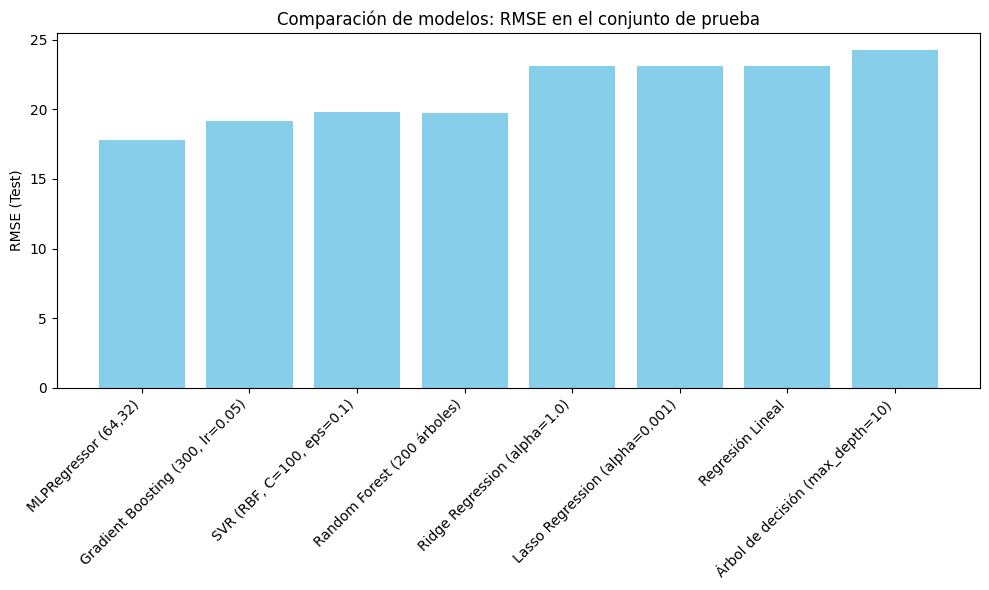

In [ ]:
# Gráfica de barras: RMSE en el conjunto de valicacion
plt.figure(figsize=(10, 6))
plt.bar(resultados_df_sorted['Modelo'], resultados_df_sorted['Val RMSE'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('RMSE (Test)')
plt.title('Comparación de modelos: RMSE en el conjunto de prueba')
plt.tight_layout()
plt.show()

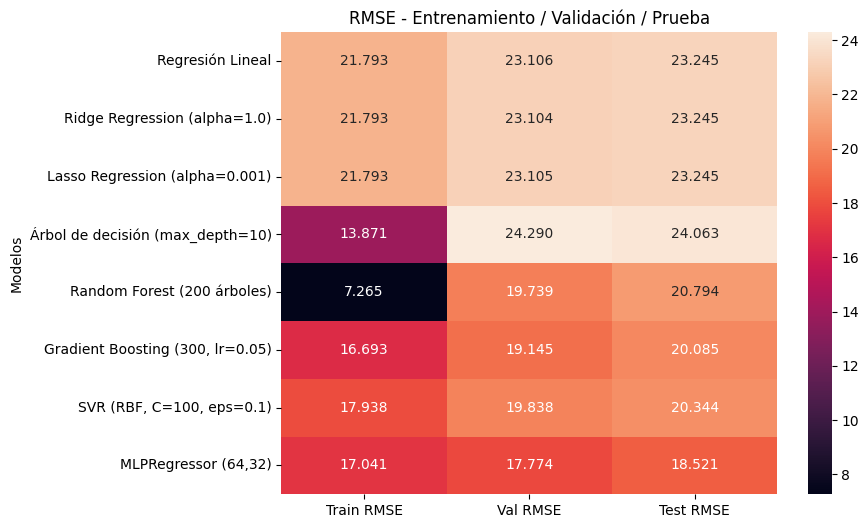

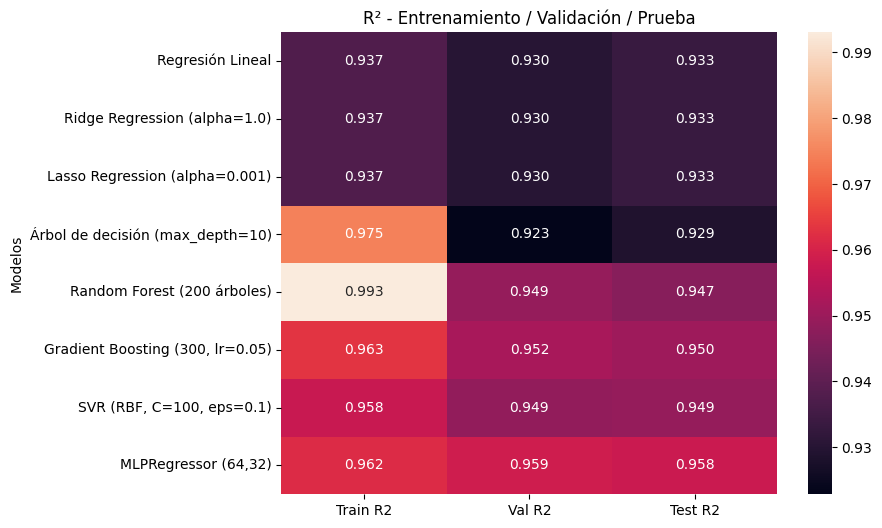

In [ ]:
# Heatmaps de RMSE y R²

# Seleccionamos solo algunas columnas de interés
metricas_rmse = resultados_df.set_index('Modelo')[['Train RMSE', 'Val RMSE', 'Test RMSE']]
metricas_r2   = resultados_df.set_index('Modelo')[['Train R2', 'Val R2', 'Test R2']]

plt.figure(figsize=(8, 6))
sns.heatmap(metricas_rmse, annot=True, fmt=".3f")
plt.title('RMSE - Entrenamiento / Validación / Prueba')
plt.ylabel('Modelos')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(metricas_r2, annot=True, fmt=".3f")
plt.title('R² - Entrenamiento / Validación / Prueba')
plt.ylabel('Modelos')
plt.show()